In [1]:
import pandas as pd 
import numpy as np 
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
import time 

In [2]:
# load data 
mbd_data = pd.read_csv('./outputs/mbd_data.csv')
clusters = json.loads(open('./outputs/clusters_sarima.json',"r").read())
cluster_keys = ["0","1","2","3","4","5","6","-1"]
mbd_data = mbd_data.sort_values(by=["cfips","first_day_of_month"]).reset_index(drop=True)
mbd_data.median_hh_inc.ffill(inplace=True)
mbd_data.pct_it_workers.ffill(inplace=True)

sc = MinMaxScaler()
mbd_data.median_hh_inc = sc.fit_transform( mbd_data.median_hh_inc.values.reshape(-1,1) ).reshape(-1)

cfips = mbd_data.cfips.unique()

In [3]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_pred) + np.abs(y_true)) / 2
    smape_val = np.mean(numerator / denominator)
    return smape_val

In [4]:
# Plot a county 

def plot_county(cfip):
#     cfip = clusters["-1"][0]
    location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 6))
    dates = pd.date_range(start='2019-08-01', end='2022-12-01', freq='MS')
    values = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values

    # Plot the line
    ax.plot(dates, values)

    # Set the axis labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Microbusiness Density')
    ax.set_title(f'{location} ( CFIP {cfip} )  ')

    # Rotate the x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Show the plot
    plt.show()

In [7]:
# Adfuller Test : Check if for any county, microbusiness density is stationary 

# cfip = clusters["-1"][1]
stationary_count = 0 
stationary_counties = []
for cfip in clusters["-1"]:
    cfip = int(cfip) 
    location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
    values = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values

    p_value = adfuller(values)[1]
    if p_value < 0.01 : 
        # reject null hypothesis . So time series is stationary 
        stationary_count += 1 
        stationary_counties.append(cfip)
stationary_count, len(clusters["-1"])

(4, 26)

In [8]:
# SARIMA model fit 
cfip = clusters["0"][0]
cfip

'5067'

In [7]:
data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values

# Fit the seasonal ARIMA model
p, d, q , P, D, Q, s = [3, 0, 0, 0, 0, 2, 12]
model = sm.tsa.statespace.SARIMAX(data[:-2], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

# Make predictions
forecast = results.forecast(steps=2)

# Print the summary of the model
# print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03000D+02    |proj g|=  7.44935D+04

At iterate    5    f=  9.28442D-01    |proj g|=  9.90973D-01
  ys=-3.082E+00  -gs= 7.019E-01 BFGS update SKIPPED

At iterate   10    f= -1.14592D+00    |proj g|=  1.91308D-01

At iterate   15    f= -1.17884D+00    |proj g|=  3.62819D-01

At iterate   20    f= -1.19611D+00    |proj g|=  4.41806D-01

At iterate   25    f= -1.21077D+00    |proj g|=  4.19966D+00

At iterate   30    f= -1.41205D+00    |proj g|=  3.97968D+00

At iterate   35    f= -1.58401D+00    |proj g|=  7.17697D+00

At iterate   40    f= -1.92902D+00    |proj g|=  4.84191D-01

At iterate   45    f= -1.94495D+00    |proj g|=  8.98347D-02

At iterate   50    f= -1.94514D+00    |proj g|=  3.02313D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


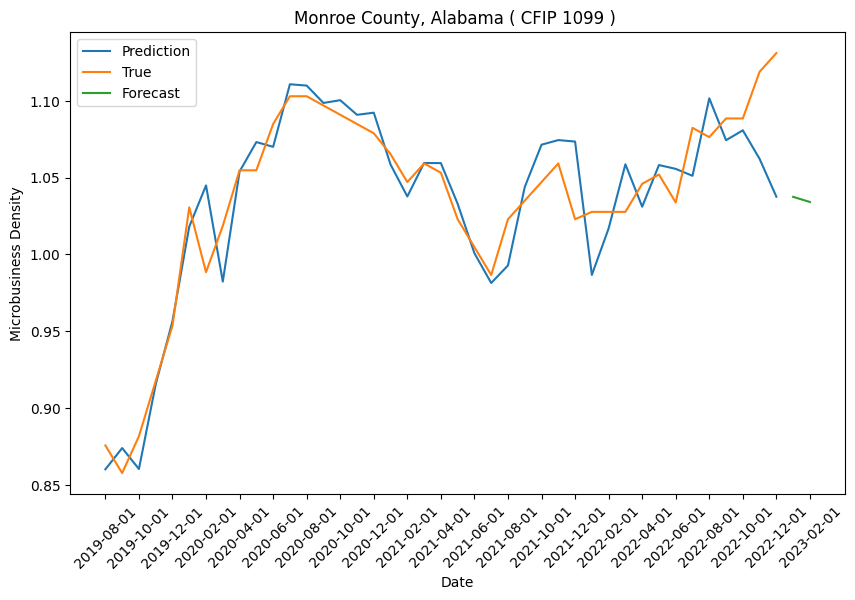

In [8]:
dates = pd.date_range(start='2019-08-01', end='2023-03-01', freq='MS')
dates = [date.strftime('%Y-%m-%d') for date in dates]

train_y_pred = results.predict()[1:]
train_y = data[1:-2]
test_y_pred = results.forecast(2)
test_y = data[-2:]   

y_pred = np.concatenate([train_y_pred, results.forecast(5)])
x = list(range(len(y_pred)))
location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
plt.figure(figsize=(10,6))
plt.plot(x[:len(data)],y_pred[:len(data)], label="Prediction")
plt.plot(x[:len(data)],data, label="True")
plt.plot(x[len(data):],y_pred[len(data):], label="Forecast")

# Set the axis labels and title
plt.xlabel('Date')
plt.ylabel('Microbusiness Density')
plt.title(f'{location} ( CFIP {cfip} ) ')
plt.xticks(x[::2], dates[::2], rotation=45)
plt.legend()
plt.show()

In [9]:
smape(results.predict()[1:],data[1:-2])

0.02423603780325595

In [10]:
smape(forecast, data[-2:])

0.048730170972919436

In [25]:
def get_cluster(cfip):
    for key in clusters: 
        if cfip in clusters[key]: 
            return key

def do_task(p,d,q,P,D,Q,s,values):
    train, test = values[:-2], values[-2:]
    try: 
        model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
        results = model.fit(disp=False)
        
        train_smape = smape(results.predict()[1:],train[1:])
        test_smape = smape(results.forecast(2),test)
        return train_smape, test_smape
    except: 
        return np.inf, np.inf


def do_major_task(p,d,q,P,D,Q,s,data, train_least_smape, test_least_smape,best_params):
    train_smape, test_smape = do_task(p,d,q,P,D,Q,s,data)
    if test_smape < test_least_smape: 
        train_least_smape = train_smape
        test_least_smape = test_smape
        best_params = [p,d,q,P,D,Q,s]
    return train_least_smape, test_least_smape, best_params

def get_best_params(cfip):
    cfip = int(cfip)
    cluster_id = get_cluster(cfip)
    data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values
    is_stationary = adfuller(data)[1] > 0.02
    if is_stationary: 
        total = 3*7*3*3*3
    else: 
        total = 3*7*3*2*3*3*2
#     pbar = tqdm(total=total)
    best_params = []
    train_least_smape = np.inf
    test_least_smape = np.inf
    cntr = 0 
    start = time.time()
    for s in range(0,13,6):
        for p in range(0,7): 
            for q in range(0,3): 
                if is_stationary: 
                    d = 0 
                    D = 0 
                    for P in range(0,3):
                        for Q in range(0,3):
                            train_least_smape, test_least_smape, best_params = do_major_task(p,d,q,P,D,Q,s,data, train_least_smape, test_least_smape,best_params)
#                             pbar.update(1)
                            cntr += 1
                            if cntr % 100 == 0 : 
                                end = time.time()
                                # print(cntr," ")
                                # print(f"{cntr}/{total}",cfip,train_least_smape, test_least_smape, best_params, (end-start) ," seconds")
                else: 
                    for d in range(0,2):
                        for P in range(0,3):
                            for Q in range(0,3):
                                for D in range(0,2): 
                                    train_least_smape, test_least_smape, best_params = do_major_task(p,d,q,P,D,Q,s,data, train_least_smape, test_least_smape,best_params)
#                                     pbar.update(1)
                                    cntr += 1
                                    if cntr % 100 == 0 : 
                                        end = time.time()
                                        
                                        # print(f"{cntr}/{total}",cfip,train_least_smape, test_least_smape, best_params, (end-start) ," seconds")
                                        # print(cntr," ")
    results = json.loads(open("./outputs/clusters_sarima2.json", "r").read())
    results[cluster_id][cfip] = {
            "train_smape" : train_least_smape,
            "val_smape": test_least_smape,
            "best_params" : best_params,
        }
    json.dump(results, open("./outputs/clusters_sarima2.json", "w"))
    return best_params,train_least_smape, test_least_smape


In [26]:
# len(cfips_all)
clusters_existing = json.load(open('./outputs/clusters_sarima.json','r'))
cfips_existing = [int(cfip) for key in clusters_existing for cfip in clusters_existing[key] ]
len(cfips_existing)

159

In [12]:
cfips_all = []
for key in clusters: 
    for cfip in clusters[key]:  
        cfips_all.append(cfip)

print(len(cfips_all))
cfips_all = [ cfip for cfip in cfips_all if cfip not in cfips_existing]
len(cfips_all)

159


159

In [23]:
import json 
results = json.loads(open("./outputs/clusters_sarima2.json", "r").read())
for key in ["-1","0","1","2","3","4","5","6"] : 
    results[key] = {}
json.dump(results, open("./outputs/clusters_sarima2.json", "w"))

In [24]:
for cfip in tqdm(cfips_all): 
    best_params,train_least_smape, test_least_smape = get_best_params(cfip)

  0%|                                                                                          | 0/159 [00:00<?, ?it/s]


ValueError: sample size is too short to use selected regression component

#### After getting best Params 

In [14]:
best_performing_counties = []

def get_cluster(cfip):
    for key in clusters: 
        if cfip in clusters[key]: 
            return key

def get_errors(p,d,q,P,D,Q,s,values):
    y_train, y_test = values[:-2], values[-2:]
    try: 
        model = sm.tsa.statespace.SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
        results = model.fit(disp=False)
        y_train_pred = results.predict()[1:]
        y_train = y_train[1:]
        y_test_pred = results.forecast(2)
        train_smape, test_smape = smape(y_train, y_train_pred), smape(y_test, y_test_pred)
        train_rmse , test_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred)), np.sqrt(mean_squared_error(y_test, y_test_pred))
        return train_smape, test_smape, train_rmse, test_rmse 
    except Exception as e: 
        print(e)
        return np.inf, np.inf, np.inf, np.inf

def train_sarima_model(cfip):
    cluster_id = get_cluster(cfip)
    result = clusters[cluster_id][str(cfip)]
    p,d,q,P,D,Q,s = result["best_params"]
    data = mbd_data[mbd_data.cfips == int(cfip)]["microbusiness_density"].values
    train_smape, test_smape, train_rmse, test_rmse = get_errors(p,d,q,P,D,Q,s,data)
    return train_smape, test_smape, train_rmse, test_rmse 


df_sarima = pd.DataFrame(columns = ["Cluster", "Size", "Train SMAPE", "Validation SMAPE", "Train RMSE", "Validation RMSE"])
df2_sarima = pd.DataFrame(columns=["cfip","Train SMAPE", "Validation SMAPE", "Train RMSE", "Validation RMSE"])
for index in [0,1,2,3,4,5,6,-1]:
    index = str(index)
    print(f"Cluster {index}")

    if len(clusters[index]) == 0 : 
        continue
    
    train_rmse_arr = []
    test_rmse_arr = []
    train_smape_arr = []
    test_smape_arr = []
    
    for cfip in tqdm(clusters[index]): 
        train_smape, test_smape, train_rmse, test_rmse = train_sarima_model(cfip)
        if test_smape < 0.02 : 
            best_performing_counties.append(cfip)
        train_rmse_arr.append(train_rmse)
        test_rmse_arr.append(test_rmse)
        train_smape_arr.append(train_smape)
        test_smape_arr.append(test_smape)
        df2_sarima.loc[len(df2_sarima.index)] = [cfip, round(train_smape,3), round(test_smape,3), round(train_rmse,3), round(test_rmse,3) ]

    df_sarima.loc[len(df_sarima.index)] = [index, len(train_smape_arr), round(np.mean(train_smape_arr),3), round(np.mean(test_smape_arr),3), round(np.mean(train_rmse_arr),3), round(np.mean(test_rmse_arr),3) ]

    


Cluster 0


  0%|                                                                                          | 0/133 [00:00<?, ?it/s]


TypeError: list indices must be integers or slices, not str

In [198]:
df_sarima

,Cluster,Size,Train SMAPE,Validation SMAPE,Train RMSE,Validation RMSE
0,0,260,0.131,0.047,0.251,0.148
1,-1,86,0.185,0.025,2.018,0.277


In [152]:
tmp_arr = df2_sarima[ (df2_sarima["Train SMAPE"] < 0.02) & (df2_sarima["Validation SMAPE"] < 0.02) ].cfip.values

In [160]:
# for cfip in tmp_arr: 
#     plot_county(int(cfip))

In [164]:
clusters

{'-1': {'1035': {'train_smape': 0.07269310694316879,
   'val_smape': 0.005999596940724404,
   'best_params': [6, 0, 2, 2, 0, 2, 12]},
  '1111': {'train_smape': 0.1343650947184502,
   'val_smape': 0.0059093706906750455,
   'best_params': [0, 0, 2, 2, 0, 2, 6]},
  '1125': {'train_smape': 0.04459033213829244,
   'val_smape': 0.0007439084123616567,
   'best_params': [4, 0, 0, 2, 0, 1, 12]},
  '1133': {'train_smape': 0.0513424695272804,
   'val_smape': 0.004068520952035816,
   'best_params': [3, 0, 0, 1, 0, 1, 6]},
  '2164': {'train_smape': 0.16108539405351235,
   'val_smape': 0.004994244615942406,
   'best_params': [0, 0, 1, 2, 0, 1, 6]},
  '5055': {'train_smape': 0.07194060840960759,
   'val_smape': 0.008923676472146778,
   'best_params': [5, 0, 2, 1, 0, 0, 6]},
  '6015': {'train_smape': 0.04372841651573825,
   'val_smape': 0.009343119399233931,
   'best_params': [5, 0, 2, 0, 0, 1, 12]},
  '8031': {'train_smape': 0.05598393638671778,
   'val_smape': 0.010825413307655636,
   'best_params':

In [156]:
# df2_sarima.loc[ df2_sarima["Validation SMAPE"] < 0.1 , "Validation SMAPE"].hist()

In [157]:
# df2_sarima.loc[ df2_sarima["Train RMSE"] < 1 , "Train RMSE"].hist()

### Benchmarking Against ARIMA 

In [94]:
results = json.load(open('./outputs/arima_params_updated.json'))

In [34]:


def get_cluster(cfip):
    for key in clusters: 
        if cfip in clusters[key]: 
            return key

def train_arima_model(cfip):
    cluster_id = get_cluster(cfip)
    result = results[cluster_id][str(cfip)]
    if result["val_original_smape"] <= result["val_clipped_smape"]: 
        p,d,q = result["best_params_original"]
        data = mbd_data[mbd_data.cfips == int(cfip)]["microbusiness_density"].values
    else: 
        p,d,q = result["best_params_clipped"]
        data = mbd_data[mbd_data.cfips == int(cfip)]["microbusiness_density"][-15:].values
    
    model = sm.tsa.ARIMA(data[:-2], order=(p, d, q))
    results1 = model.fit()
    train_y_pred = results1.predict()[1:]
    train_y = data[1:-2]
    test_y_pred = results1.forecast(2)
    test_y = data[-2:]
    
    
    train_smape = smape(train_y, train_y_pred)
    test_smape = smape(test_y, test_y_pred)
    train_rmse = np.sqrt(mean_squared_error(train_y,train_y_pred))
    test_rmse = np.sqrt( mean_squared_error(test_y, test_y_pred))
    
    return train_smape, test_smape, train_rmse, test_rmse


df_arima = pd.DataFrame(columns = ["Cluster", "Size", "Train SMAPE", "Validation SMAPE", "Train RMSE", "Validation RMSE"])
df2_arima = pd.DataFrame(columns=["cfip","Train SMAPE", "Validation SMAPE", "Train RMSE", "Validation RMSE"])
for index in [0,1,2,3,4,5,6,-1]:
    index = str(index)
    print(f"Cluster {index}")

    if len(clusters[index]) == 0 : 
        continue
    
    train_rmse_arr = []
    test_rmse_arr = []
    train_smape_arr = []
    test_smape_arr = []
    
    for cfip in tqdm(clusters[index]): 
        train_smape, test_smape, train_rmse, test_rmse = train_arima_model(cfip)
        train_rmse_arr.append(train_rmse)
        test_rmse_arr.append(test_rmse)
        train_smape_arr.append(train_smape)
        test_smape_arr.append(test_smape)
        df2_arima.loc[len(df2_arima.index)] = [cfip, round(train_smape,3), round(test_smape,3), round(train_rmse,3), round(test_rmse,3) ]
        
    df_arima.loc[len(df_arima.index)] = [index, len(train_smape_arr), round(np.mean(train_smape_arr),3), round(np.mean(test_smape_arr),3), round(np.mean(train_rmse_arr),3), round(np.mean(test_rmse_arr),3) ]


Cluster 0


100%|██████████| 260/260 [00:28<00:00,  9.21it/s]


Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5
Cluster 6
Cluster -1


100%|██████████| 86/86 [00:06<00:00, 13.68it/s]


In [32]:
df_arima

,Cluster,Size,Train SMAPE,Validation SMAPE,Train RMSE,Validation RMSE
0,0,260,0.040,0.066,0.069,0.183
1,-1,86,0.079,0.057,1.421,0.588


In [52]:
df2_sarima[ (df2_sarima["Train SMAPE"] < 0.05) & (df2_sarima["Validation SMAPE"] < 0.02) ]

,cfip,Train SMAPE,Validation SMAPE,Train RMSE,Validation RMSE
0,2050,0.046,0.019,0.044,0.018
2,1099,0.028,0.004,0.037,0.005
3,5039,0.038,0.002,0.028,0.001
5,5075,0.024,0.005,0.055,0.006
11,8103,0.022,0.003,0.094,0.013
...,...,...,...,...,...
327,48101,0.043,0.017,0.127,0.063
330,48221,0.016,0.001,0.279,0.010
339,51610,0.011,0.018,0.365,0.448
340,53033,0.013,0.002,0.782,0.036


In [190]:
df2_sarima[ np.abs((df2_sarima["Train SMAPE"] - df2_sarima["Validation SMAPE"]).values) > 0.3 ].shape

(41, 5)

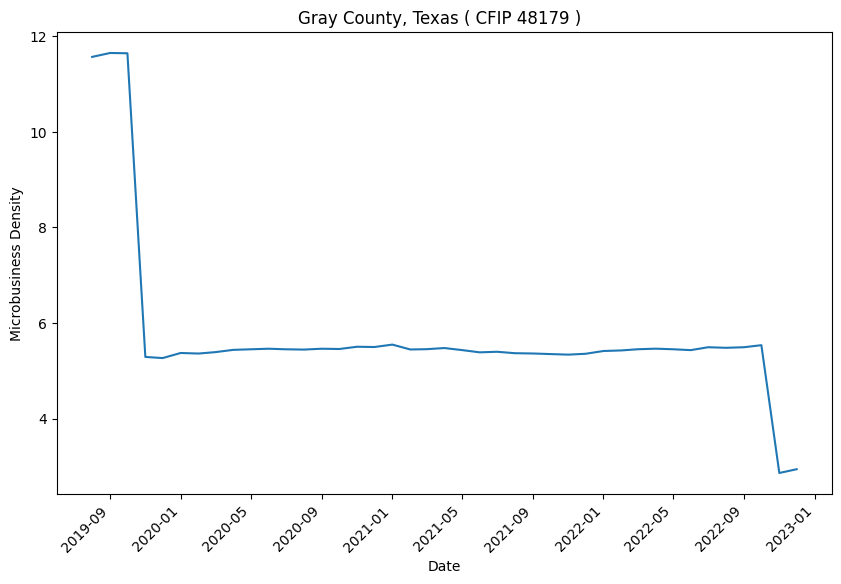

In [183]:
plot_county(48179)

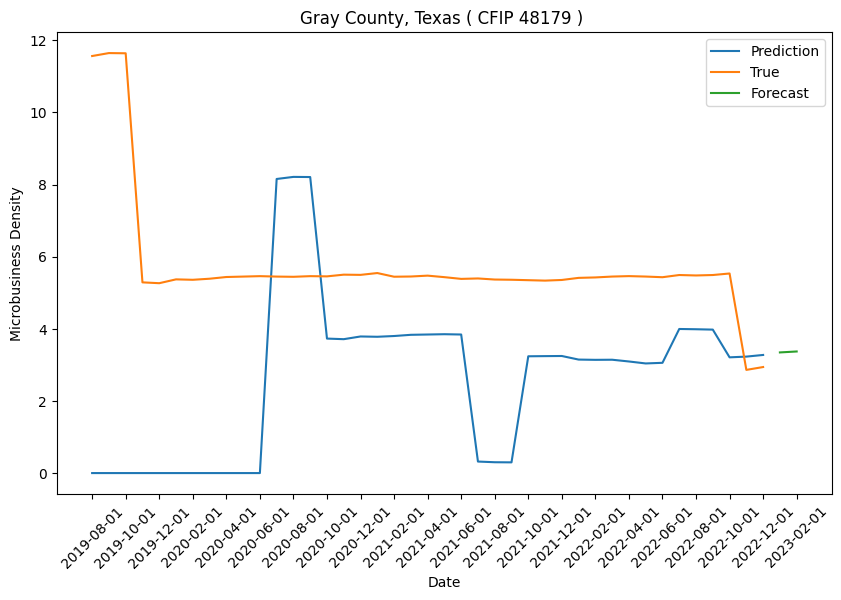

In [184]:
tmp_arr2 = [48179]


cfip = str(tmp_arr2[0])
cluster_id = get_cluster(cfip)
result = clusters[cluster_id][str(cfip)]
p,d,q,P,D,Q,s = result["best_params"]
data = mbd_data[mbd_data.cfips == int(cfip)]["microbusiness_density"].values
dates = pd.date_range(start='2019-08-01', end='2023-03-01', freq='MS')
dates = [date.strftime('%Y-%m-%d') for date in dates]
y_train, y_test = data[:-2], data[-2:]
model = sm.tsa.statespace.SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
results1 = model.fit(disp=False)
train_y_pred = results1.predict()[1:]
train_y = y_train[1:]
test_y_pred = results1.forecast(2)

y_pred = np.concatenate([train_y_pred, results1.forecast(5)])
x = list(range(len(y_pred)))
location = mbd_data[mbd_data.cfips == int(cfip)].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == int(cfip)].state.iloc[0]
plt.figure(figsize=(10,6))
plt.plot(x[:len(data)],y_pred[:len(data)], label="Prediction")
plt.plot(x[:len(data)],data, label="True")
plt.plot(x[len(data):],y_pred[len(data):], label="Forecast")

# Set the axis labels and title
plt.xlabel('Date')
plt.ylabel('Microbusiness Density')
plt.title(f'{location} ( CFIP {cfip} ) ')
plt.xticks(x[::2], dates[::2], rotation=45)
plt.legend()
plt.show()






<Axes: >

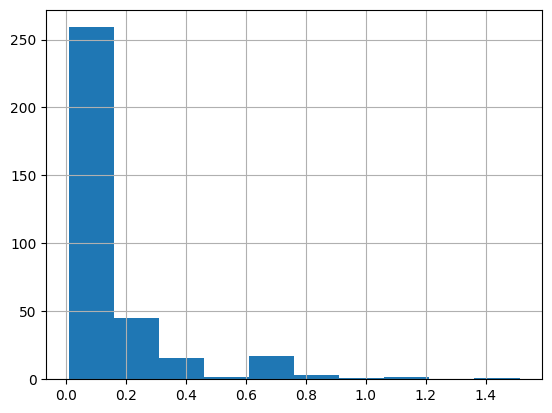

In [47]:
df2_sarima["Train SMAPE"].hist()

In [95]:


# def get_cluster2(cfip):
#     for key in results: 
#         if cfip in results[key]: 
#             return key

# def train_arima_model(cfip):
#     cluster_id = get_cluster2(cfip)
#     result = results[cluster_id][str(cfip)]
#     if result["val_original_smape"] <= result["val_clipped_smape"]: 
#         p,d,q = result["best_params_original"]
#         data = mbd_data[mbd_data.cfips == int(cfip)]["microbusiness_density"].values
#     else: 
#         p,d,q = result["best_params_clipped"]
#         data = mbd_data[mbd_data.cfips == int(cfip)]["microbusiness_density"][-15:].values
    
#     model = sm.tsa.ARIMA(data[:-2], order=(p, d, q))
#     results1 = model.fit()
#     train_y_pred = results1.predict()[1:]
#     train_y = data[1:-2]
#     test_y_pred = results1.forecast(2)
#     test_y = data[-2:]
    
    
#     train_smape = smape(train_y, train_y_pred)
#     test_smape = smape(test_y, test_y_pred)
#     train_rmse = np.sqrt(mean_squared_error(train_y,train_y_pred))
#     test_rmse = np.sqrt( mean_squared_error(test_y, test_y_pred))
    
#     return train_smape, test_smape, train_rmse, test_rmse


# df_arima2 = pd.DataFrame(columns = ["Cluster", "Size", "Train SMAPE", "Validation SMAPE", "Train RMSE", "Validation RMSE"])
# df2_arima2 = pd.DataFrame(columns=["cfip","Train SMAPE", "Validation SMAPE", "Train RMSE", "Validation RMSE"])
# for index in [0,1,2,3,4,5,6,-1]:
#     index = str(index)
#     print(f"Cluster {index}")

#     if index not in results or len(results[index]) == 0 : 
#         continue
    
    
#     train_rmse_arr = []
#     test_rmse_arr = []
#     train_smape_arr = []
#     test_smape_arr = []
    
#     for cfip in tqdm(results[index]): 
#         train_smape, test_smape, train_rmse, test_rmse = train_arima_model(cfip)
#         train_rmse_arr.append(train_rmse)
#         test_rmse_arr.append(test_rmse)
#         train_smape_arr.append(train_smape)
#         test_smape_arr.append(test_smape)
#         df2_arima2.loc[len(df2_arima2.index)] = [cfip, round(train_smape,3), round(test_smape,3), round(train_rmse,3), round(test_rmse,3) ]
        
#     df_arima2.loc[len(df_arima2.index)] = [index, len(train_smape_arr), round(np.mean(train_smape_arr),3), round(np.mean(test_smape_arr),3), round(np.mean(train_rmse_arr),3), round(np.mean(test_rmse_arr),3) ]


In [96]:
# df2_arima2[ (df2_arima2["Train SMAPE"] < 0.05 ) & (df2_arima2["Validation SMAPE"] < 0.02) ].shape[0]

In [97]:
# df_arima2

In [105]:
# sarima_params = {}

# for key in clusters: 
#     for cfip in clusters[key]: 
#         sarima_params[cfip] = clusters[key][cfip]

# json.dump(sarima_params, open("./outputs/sarima_params.json", "w"))

In [202]:
clusters_sarima2 = {}
for key in clusters: 
    clusters_sarima2[key] = []
    for cfip in clusters[key]: 
        if cfip not in best_performing_counties: 
            clusters_sarima2[key].append(cfip)
# clusters_sarima2

In [203]:
json.dump(clusters_sarima2, open("./outputs/holt_clusters.json", "w"))